In [583]:
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
import plotly.express as px
import plotly.graph_objects as go

In [584]:
df = pd.read_csv("/home/lucasleao/bootstrapping-intervals/data/risk_factors_cervical_cancer.csv")

# Exemplo de uso:
data = df[df["Dx:Cancer"] == 1]["Age"]
num_samples = len(data)
num_iterations = 1000

In [585]:
results = pd.DataFrame(columns=["Metric", "Method", "MarginError", "CILower", "CIUpper"])

In [586]:
def generate_ci_graph(data, estimated_statistic, ci, confidence_level, fig_type=None):
    """
    Generates a histogram with a line indicating the mean and a confidence interval bar.

    Parameters:
    - data (list or array): Dataset to be plotted in the histogram.
    - estimated_statistic (float): Estimated statistic (e.g., mean) to be marked on the histogram.
    - ci (tuple): Pair of values representing the confidence interval (lower and upper limits).
    - confidence_level (float): Confidence level of the interval (e.g., 0.95 for 95%).
    - fig_type (str, optional): Type of figure to be displayed (default is None).

    Returns:
    - fig (plotly.graph_objects.Figure): Plotly figure object with the histogram and annotations.

    """

    fig = px.histogram(data, opacity=0.5)
    
    # Add line indicating the estimated statistic
    fig.add_vline(x=estimated_statistic, line_dash='dash', line_color='firebrick')
    
    # Add confidence interval bar
    fig.add_vrect(x0=ci[0], x1=ci[1], line_width=0, fillcolor='lightgrey', opacity=0.5)
    
    # Add invisible trace for confidence interval legend entry
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=10, color='lightgrey'), showlegend=True, name=f'Confidence Interval {confidence_level * 100}%'))
    
    # Add annotations for lower and upper confidence interval limits
    fig.add_annotation(x=ci[0], y=confidence_level, xref='x', yref='paper', text=ci[0], showarrow=True, arrowhead=0, ax=0, ay=-30)
    fig.add_annotation(x=ci[1], y=confidence_level, xref='x', yref='paper', text=ci[1], showarrow=True, arrowhead=0, ax=0, ay=-30)
    fig.update_layout(title="Data Distribution with Confidence Interval", width=800, height=500)
    return fig.show(fig_type)


Boostrapping Normal Interval Confidence

In [587]:
def normal_bootstrapping(data, confidence_level, statistic=np.mean, num_iterations=1000):
    """
        Calculates the normal bootstrap confidence interval for the mean of a statistic.

    Parameters:
    - data (array-like): The input data for bootstrapping.
    - confidence_level (float): The confidence level for the confidence interval.
    - statistic (function): The statistic to calculate for each bootstrap sample. Defaults to np.mean.
    - num_iterations (int): The number of bootstrap iterations to perform. Defaults to 1000.

    Returns:
    - tuple: A tuple containing the margin of error and the confidence interval of the statistic.

    Purpose:
    This implementation utilizes the normal distribution method to calculate the confidence interval.
    """
    np.random.seed(42)
    n = len(data)

    def calculate_bootstrap_statistics(data, statistic, num_iterations):
        """
        Performs bootstrap resampling on the given data and calculates the specified statistic for each resample.

        Parameters:
        - data (array-like): Sample data.
        - statistic (function): Statistical function to apply to the data.
        - num_iterations (int): Number of bootstrap resamples to perform. Default is 1000.

        Returns:
        - numpy array: Array of calculated statistics for each bootstrap resample.
        """
        sample_statistics = np.zeros(num_iterations)
        
        for i in range(num_iterations):
            resample = np.random.choice(data, size=n, replace=True)
            sample_statistics[i] = statistic(resample)
        
        return sample_statistics
    
    sample_statistics = calculate_bootstrap_statistics(data, statistic, num_iterations)
    # Calculate the z-score corresponding to the desired confidence level
    z_score = norm.ppf((1 + confidence_level) / 2)
    se_value = sample_statistics.std() / math.sqrt(n)
    margin_error = z_score * se_value
    
    return margin_error, [round(sample_statistics.mean() - margin_error, 2), round(sample_statistics.mean() + margin_error, 2)]


In [588]:
margin_error, ci = normal_bootstrapping(data.values, 0.95)

In [589]:
results.loc[0] = ["mean", "Normal", margin_error, ci[0], ci[1]]

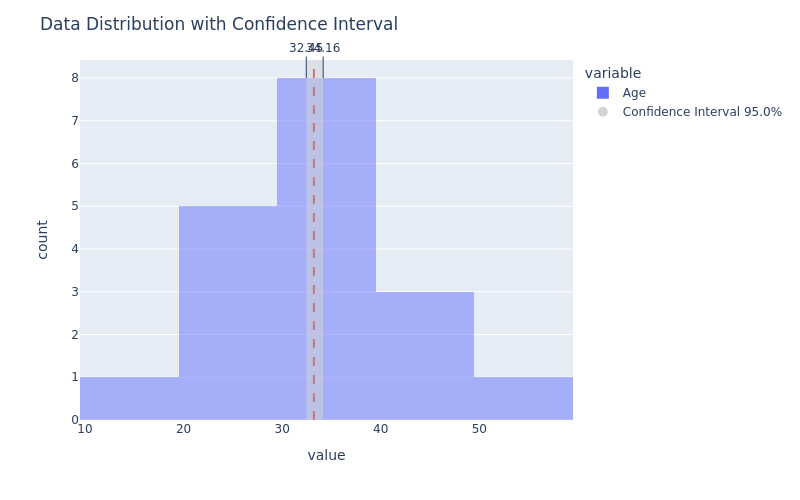

In [590]:
generate_ci_graph(data, data.mean(), ci, confidence_level=0.95, fig_type="png")

In [591]:
margin_error, ci = normal_bootstrapping(data, 0.95, np.std)

In [592]:
results.loc[1] = ["std", "Normal", margin_error, ci[0], ci[1]]

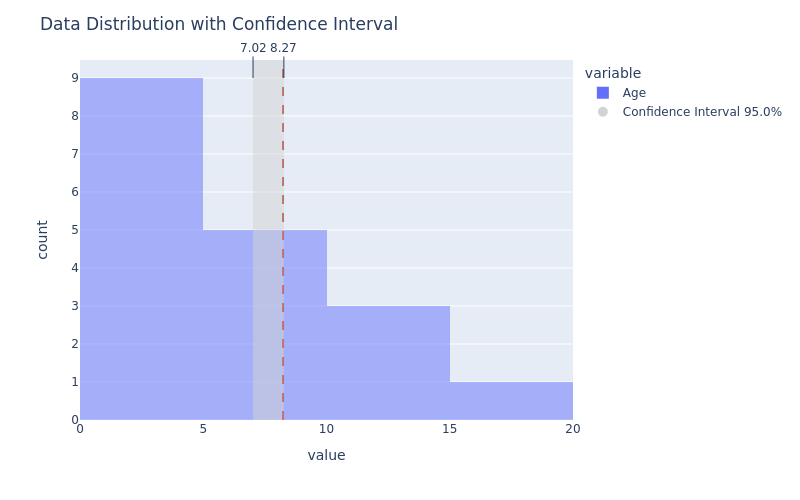

In [593]:
generate_ci_graph(np.sqrt((data.mean() - data) ** 2), data.std(), ci, confidence_level=0.95, fig_type="png")

Boostrapping Percentile Interval Confidence

In [594]:
def percentile_bootstrapping(data, confidence_level, statistic=np.mean, num_iterations=1000):
    """
    Calculates the percentile bootstrap confidence interval for the mean of a statistic.

    Parameters:
    - data (list or numpy array): Sample data.
    - confidence_level (float): Desired confidence level (e.g., 0.95 for 95%).
    - statistic (function): Statistical function to apply to the data. Default is np.mean.
    - num_resamples (int): Number of bootstrap resamples to perform. Default is 1000.

    Returns:
    - list: List containing the lower and upper bounds of the confidence interval rounded to two decimal places.

    """
    np.random.seed(42)
    n = len(data)

    def calculate_bootstrap_statistics(data, statistic, num_iterations):
        """
        Performs bootstrap resampling on the given data and calculates the specified statistic for each resample.

        Parameters:
        - data (list or numpy array): Sample data.
        - statistic (function): Statistical function to apply to the data.
        - num_resamples (int): Number of bootstrap resamples to perform. Default is 1000.

        Returns:
        - numpy array: Array of calculated statistics for each bootstrap resample.
        """
        sample_statistics = np.zeros(num_iterations)
        
        for i in range(num_iterations):
            resample = np.random.choice(data, size=n, replace=True)
            sample_statistics[i] = statistic(resample)
        
        return sample_statistics


    sample_statistics = calculate_bootstrap_statistics(data, statistic, num_iterations)

    # Calculating percentile interval
    lower_bound = np.percentile(sample_statistics, (1 - confidence_level) / 2 * 100)
    upper_bound = np.percentile(sample_statistics, (1 + confidence_level) / 2 * 100)

    se_value = np.std(sample_statistics)
    z_alpha = norm.ppf((1 + confidence_level) / 2)
    margin_error = se_value * z_alpha

    return margin_error, [round(lower_bound, 2), round(upper_bound, 2)]

In [595]:
margin_error, ci = percentile_bootstrapping(data, 0.95)

In [596]:
results.loc[2] = ["mean", "Percentile", margin_error, ci[0], ci[1]]

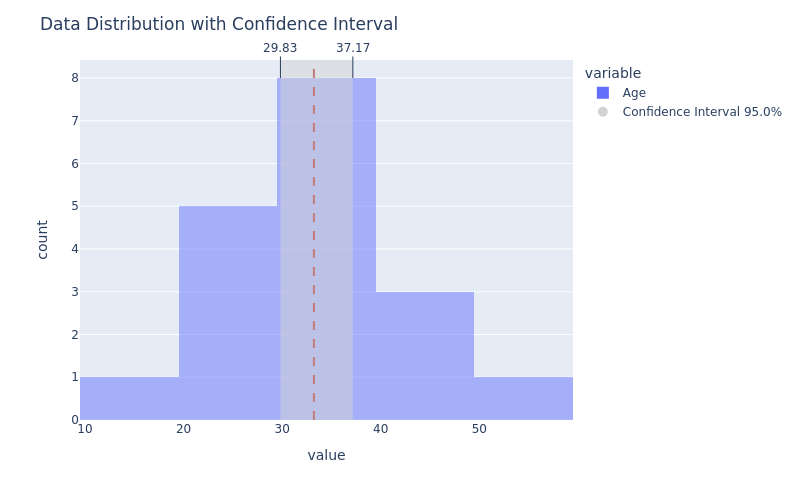

In [597]:
generate_ci_graph(data, data.mean(), ci, confidence_level=0.95, fig_type="png")

In [598]:
margin_error, ci = percentile_bootstrapping(data, 0.95, np.std)

In [599]:
results.loc[2] = ["std", "Percentile", margin_error, ci[0], ci[1]]

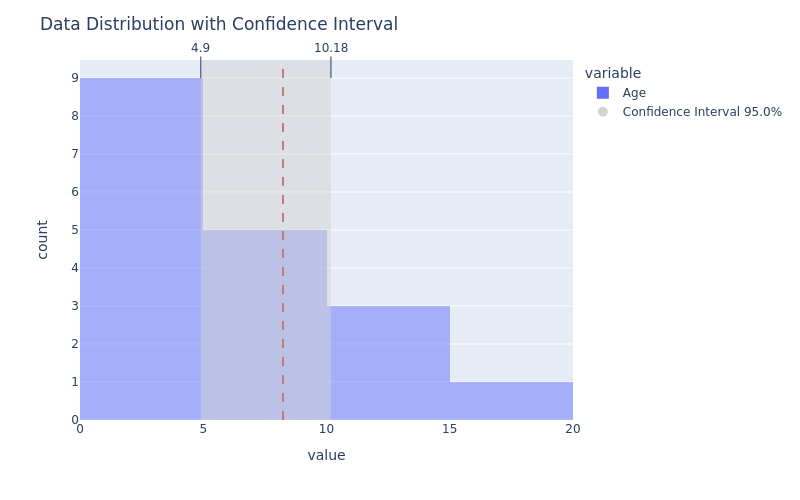

In [600]:
generate_ci_graph(np.sqrt((data.mean() - data) ** 2), data.std(), ci, confidence_level=0.95, fig_type="png")

Basic Bootstrap Confidence Interval

In [601]:
def basic_bootstrapping(data, confidence_level, statistic=np.mean, num_iterations=1000):
    """
    Calculate the basic bootstrap confidence interval for the given statistic.

    Parameters:
    - data (list or numpy array): Sample data. This represents the original sample from which the bootstrap samples will be drawn.
    - confidence_level (float): Desired confidence level for the interval (e.g., 0.95 for 95% confidence). This defines the degree of certainty we want for our confidence interval.
    - statistic (function): Statistical function to apply to the data (default is np.mean). This is the function used to compute the statistic of interest from the data, such as mean or median.
    - num_iterations (int): Number of bootstrap resamples to perform (default is 1000). This is the number of times the resampling procedure will be repeated to generate the bootstrap distribution.

    Returns:
    - tuple: A tuple containing:
        - observed_stat (float): The point estimate of the statistic based on the original sample.
        - confidence_interval (list): A list containing the lower and upper bounds of the bias-corrected and accelerated (BCa) bootstrap confidence interval.
    """
    np.random.seed(42)
    n = len(data)

    def calculate_bootstrap_statistics(data, statistic, num_iterations):
        """
        Performs bootstrap resampling on the given data and calculates the specified statistic for each resample.

        Parameters:
        - data (list or numpy array): Sample data. The data to be resampled with replacement.
        - statistic (function): Statistical function to apply to the data. Function used to compute the statistic of interest.
        - num_iterations (int): Number of bootstrap resamples to perform (default is 1000). Number of bootstrap samples to generate.

        Returns:
        - numpy array: Array of calculated statistics for each bootstrap resample.

        """
        sample_statistics = np.zeros(num_iterations)
        
        for i in range(num_iterations):
            resample = np.random.choice(data, size=n, replace=True)
            sample_statistics[i] = statistic(resample)
        
        return sample_statistics

    # Perform bootstrap resampling
    sample_statistics = calculate_bootstrap_statistics(data, statistic, num_iterations)
    
    # Calculate the observed statistic from the original sample
    observed_stat = statistic(data)
    
    # Calculate bias correction
    bias = np.mean(sample_statistics) - observed_stat
    
    # Calculate standard error of the bootstrap sample statistics
    se_value = np.std(sample_statistics)
    
    # Calculate the z-score corresponding to the desired confidence level
    z_score = norm.ppf((1 + confidence_level) / 2)
    
    # Calculate margin of error
    margin_error = z_score * se_value
    
    # Calculate the confidence interval bounds
    ci_lower = round(observed_stat - bias - margin_error, 2)
    ci_upper = round(observed_stat - bias + margin_error, 2)
    
    return margin_error, [ci_lower, ci_upper]


In [602]:
# Definir a estatística de interesse (por exemplo, média)
margin_error, ci = basic_bootstrapping(data.values, 0.95, np.mean)

In [603]:
results.loc[3] = ["mean", "Basic", margin_error, ci[0], ci[1]]

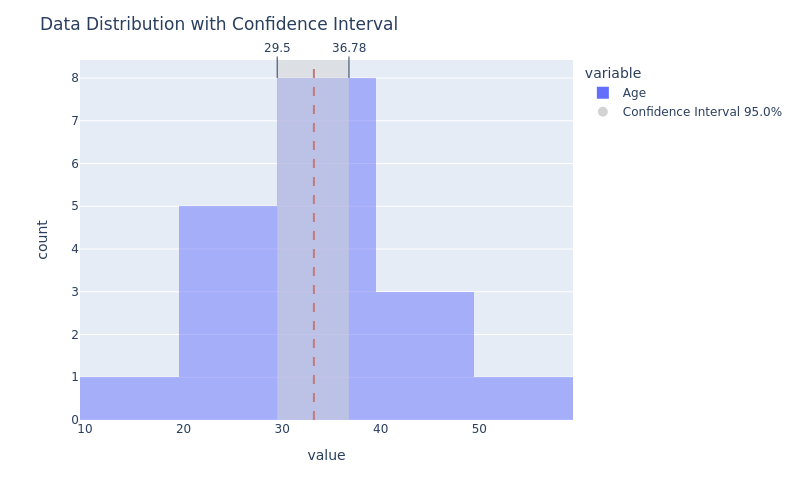

In [604]:
generate_ci_graph(data, data.mean(), ci, confidence_level=0.95, fig_type="png")

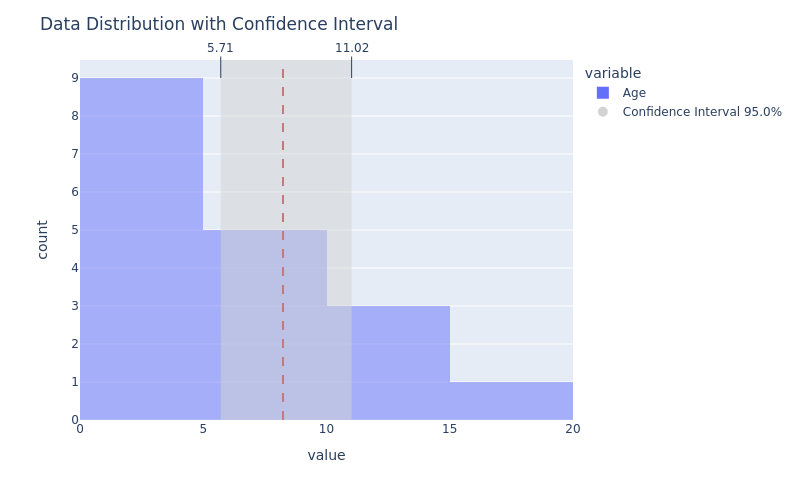

In [605]:
# Definir a estatística de interesse (por exemplo, média)
margin_error, ci = basic_bootstrapping(data.values, 0.95, np.std)
results.loc[4] = ["std", "Basic", margin_error, ci[0], ci[1]]
generate_ci_graph(np.sqrt((data.mean() - data) **2), data.std(), ci, confidence_level=0.95, fig_type="png")

Better bootstrap confidence interval (BCa)

In [606]:
def bootstrapping_bca(data, confidence_level, statistic=np.mean, num_iterations=1000):
    """
    Calculates the bias-corrected and accelerated (BCa) bootstrap confidence interval for the given data.

    Parameters:
    - data (list or numpy array): Sample data.
    - confidence_level (float): Desired confidence level (e.g., 0.95 for 95%).
    - statistic (function): Statistical function to apply to the data. Default is np.mean.
    - num_resamples (int): Number of bootstrap resamples to perform. Default is 1000.

    Returns:
    - tuple: A tuple containing the point estimate and a list with the lower and upper bounds of the BCa confidence interval, rounded to two decimal places.
    """
    np.random.seed(42)
    n = len(data)

    def generate_acceleration(data):
        """
        Calculates the jackknife resampling means and returns the acceleration.

        Parameters:
        - data (list or numpy array): Sample data.

        Returns:
        - float: Acceleration value calculated from jackknife samples.
        """
        
        jackknife_means = np.zeros(n)
        
        for i in range(n):
            jackknife_sample = np.delete(data, i)  # Remove one observation
            jackknife_means[i] = np.mean(jackknife_sample)
        
        jackknife_mean = np.mean(jackknife_means)
        jackknife_diffs = jackknife_means - jackknife_mean
        acceleration = np.sum(jackknife_diffs ** 3) / (6.0 * (np.sum(jackknife_diffs ** 2) ** 1.5))
        
        return acceleration

    def calculate_bootstrap_statistics(data, statistic, num_iterations):
        """
        Performs bootstrap resampling on the given data and calculates the specified statistic for each resample.

        Parameters:
        - data (list or numpy array): Sample data.
        - statistic (function): Statistical function to apply to the data.
        - num_resamples (int): Number of bootstrap resamples to perform. Default is 1000.

        Returns:
        - numpy array: Array of calculated statistics for each bootstrap resample.
        """
        sample_statistics = np.zeros(num_iterations)
        
        for i in range(num_iterations):
            resample = np.random.choice(data, size=n, replace=True)
            sample_statistics[i] = statistic(resample)
        
        return sample_statistics

    # Bootstrap resampling 
    sample_statistics = calculate_bootstrap_statistics(data, statistic, num_iterations)
    
    # Bias correction
    observed_stat = statistic(data)
    se_value = np.std(sample_statistics)
    
    bias = np.sum(sample_statistics < observed_stat) / num_iterations
    
    # Jackknife resampling
    acceleration = generate_acceleration(data)
    
    # Calculating BCa interval
    z0 = norm.ppf(bias)
    z_alpha = norm.ppf((1 + confidence_level) / 2)
    margin_error = z_alpha * se_value
    lower_bound = np.percentile(sample_statistics, norm.cdf(z0 + (z0 - z_alpha) / (1 - acceleration * (z0 - z_alpha))) * 100)
    upper_bound = np.percentile(sample_statistics, norm.cdf(z0 + (z0 + z_alpha) / (1 + acceleration * (z0 + z_alpha))) * 100)
    
    return margin_error, [round(lower_bound, 2), round(upper_bound, 2)]


In [607]:
# Definir a estatística de interesse (por exemplo, média)
margin_error, ci = bootstrapping_bca(data.values, 0.95, np.mean)

In [608]:
results.loc[4] = ["mean", "BCa", margin_error, ci[0], ci[1]]

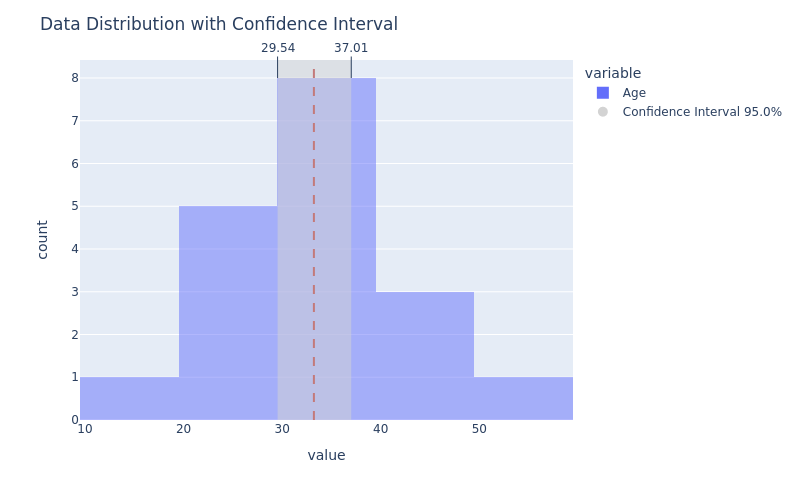

In [609]:
generate_ci_graph(data, data.mean(), ci, confidence_level=0.95, fig_type="png")

In [610]:
margin_error, ci = bootstrapping_bca(data.values, 0.95, np.std)

In [611]:
results.loc[5] = ["std", "BCa", margin_error, ci[0], ci[1]]

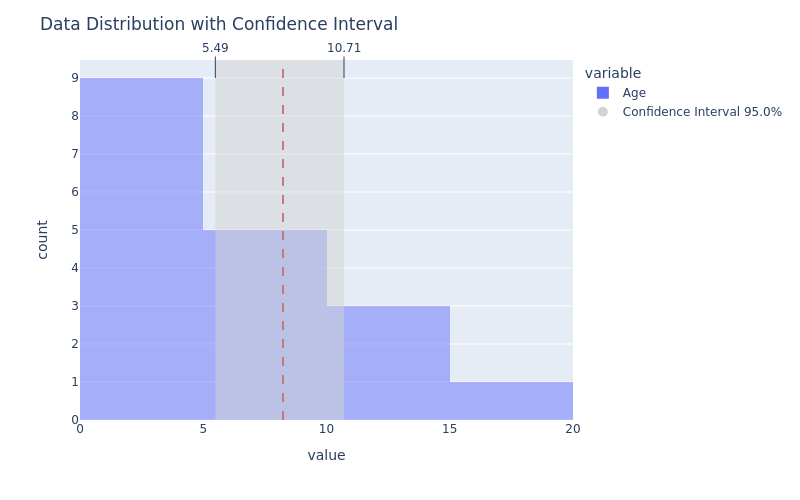

In [612]:
generate_ci_graph(np.sqrt((data.mean() - data) ** 2), data.std(), ci, confidence_level=0.95, fig_type="png")

Studentized Confidence Interval

In [613]:
def student_bootstrapping(data, confidence_level, statistic=np.mean, num_iterations=1000):
    """
    Calculates the student bootstrap confidence interval for the given data using the specified statistic.

    Parameters:
    - data (list or numpy array): Sample data.
    - confidence_level (float): Desired confidence level (e.g., 0.95 for 95%).
    - statistic (function): Statistical function to apply to the data. Default is np.mean.
    - num_iterations (int): Number of bootstrap resamples to perform. Default is 1000.

    Returns:
    - tuple: A tuple containing the point estimate, the standard error, the margin of error, and a list with the lower and upper bounds of the studentized bootstrap confidence interval rounded to two decimal places.
    """
    np.random.seed(42)
    n = len(data)

    def calculate_bootstrap_statistics(data, statistic, num_iterations):
        """
        Performs bootstrap resampling on the given data, calculates the specified statistic for each resample,
        and computes the standard error for each resample statistic.

        Parameters:
        - data (list or numpy array): Sample data.
        - statistic (function): Statistical function to apply to the data.
        - num_iterations (int): Number of bootstrap resamples to perform.
        - n (int): Size of the sample data.

        Returns:
        - tuple: Two numpy arrays containing the bootstrap resample statistics and their standard errors.
        """
        sample_stats = np.zeros(num_iterations)
        sample_stds = np.zeros(num_iterations)
        
        for i in range(num_iterations):
            resample = np.random.choice(data, size=n, replace=True)
            sample_stats[i] = statistic(resample)
            sample_stds[i] = np.std(resample, ddof=1) / np.sqrt(n)  # Standard error of the resample statistic
        
        return sample_stats, sample_stds

    # Bootstrap resampling and statistics calculation
    sample_stats, sample_stds = calculate_bootstrap_statistics(data, statistic, num_iterations)
    
    theta_hat = statistic(data)
    theta_std = np.std(data, ddof=1) / np.sqrt(n)
    t_values = (sample_stats - theta_hat) / sample_stds
    
    lower_percentile = np.percentile(t_values, (1 - confidence_level) / 2 * 100)
    upper_percentile = np.percentile(t_values, (1 + confidence_level) / 2 * 100)
    
    lower_bound = theta_hat - upper_percentile * theta_std
    upper_bound = theta_hat - lower_percentile * theta_std
    
    # Calculate standard error
    standard_error = np.std(sample_stats)
    
    # Calculate margin of error
    z_alpha = norm.ppf((1 + confidence_level) / 2)
    margin_error = z_alpha * standard_error
    
    return margin_error, [round(lower_bound, 2), round(upper_bound, 2)]


In [614]:
margin_error, ci = student_bootstrapping(data, 0.95)

In [615]:
results.loc[6] = ["mean", "Student", margin_error, ci[0], ci[1]]

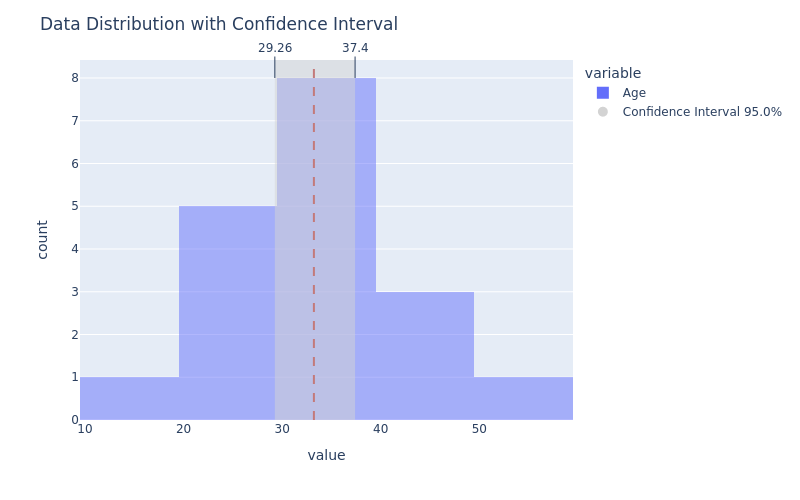

In [616]:
generate_ci_graph(data, data.mean(), ci, confidence_level=0.95, fig_type="png")

In [617]:
margin_error, ci = student_bootstrapping(data, 0.95, np.std)

In [618]:
results.loc[7] = ["std", "Student", margin_error, ci[0], ci[1]]

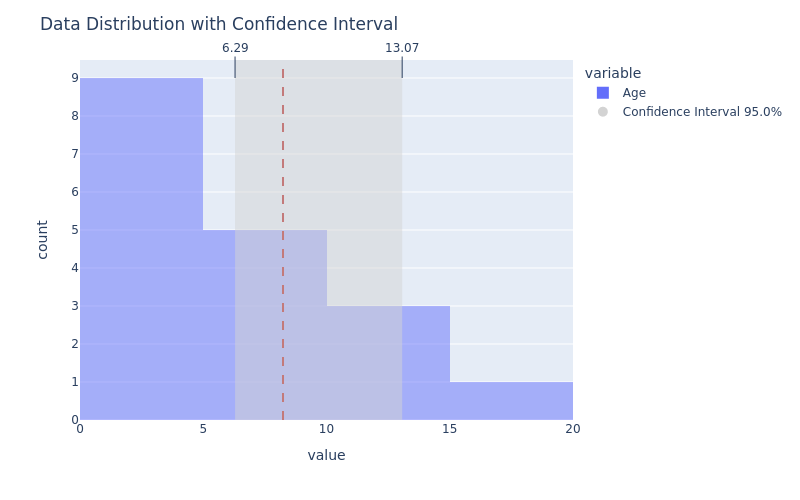

In [619]:
generate_ci_graph(np.sqrt((data.mean() - data) ** 2), data.std(), ci, confidence_level=0.95, fig_type="png")

In [620]:
def create_margin_error_histogram(results, metric, title, fig_type=None):
    df = results.loc[results["Metric"] == metric, ["Method", "MarginError"]]
    fig = px.histogram(x=df["Method"], y=df["MarginError"])
    fig.update_layout(
        title=title, 
        width=500, 
        height=400,
        xaxis_title="Method", 
        yaxis_title="MarginError")
    fig.update_traces(hovertemplate="%{y}")
    return fig.show(fig_type)


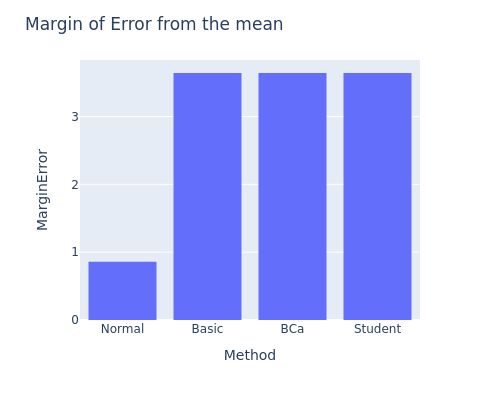

In [621]:
create_margin_error_histogram(results, "mean", title = "Margin of Error from the mean", fig_type="png")

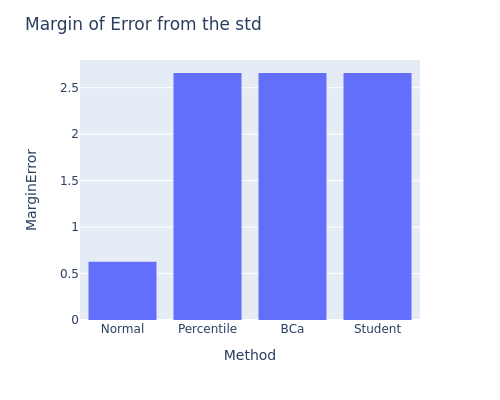

In [622]:
create_margin_error_histogram(results, "std", title = "Margin of Error from the std", fig_type="png")

In [623]:
results[results["Metric"] == "std"]

,Metric,Method,MarginError,CILower,CIUpper
1,std,Normal,0.626545,7.02,8.27
2,std,Percentile,2.658207,4.90,10.18
5,std,BCa,2.658207,5.49,10.71
7,std,Student,2.658207,6.29,13.07


In [624]:
def plot_confidence_intervals(method_names, lower_bounds, upper_bounds, statistic, fig_type=None):
    """
    Plots the confidence intervals of different methods using Plotly,
    along with a horizontal line representing the estimated statistic.

    Parameters:
    - method_names: List of method names.
    - lower_bounds: List of lower bounds of the confidence intervals.
    - upper_bounds: List of upper bounds of the confidence intervals.
    - statistic: A single statistic value to be represented across all methods.
    - fig_type: Optional parameter to specify the figure type.
    """
    fig = go.Figure()

    # Plotting the confidence intervals
    for method, lower, upper in zip(method_names, lower_bounds, upper_bounds):
        fig.add_trace(go.Scatter(
            x=[method, method],
            y=[lower, upper],
            mode='lines',
            name=f'{method} CI'
        ))

    # Adding a horizontal line for the mean
    fig.add_shape(
        type="line",
        x0=-0.5,  # Start slightly before the first method
        y0=statistic,
        x1=len(method_names) - 0.5,  # End slightly after the last method
        y1=statistic,
        line=dict(color="Red", width=2, dash='dash'),
        opacity=0.5,
        name='Estimated Statistic'
    )

    fig.update_layout(
        title="Confidence Intervals with Estimated Statistic Line",
        xaxis_title="Methods",
        yaxis_title="Value",
        showlegend=True,
    )
    
    return fig.show(fig_type)

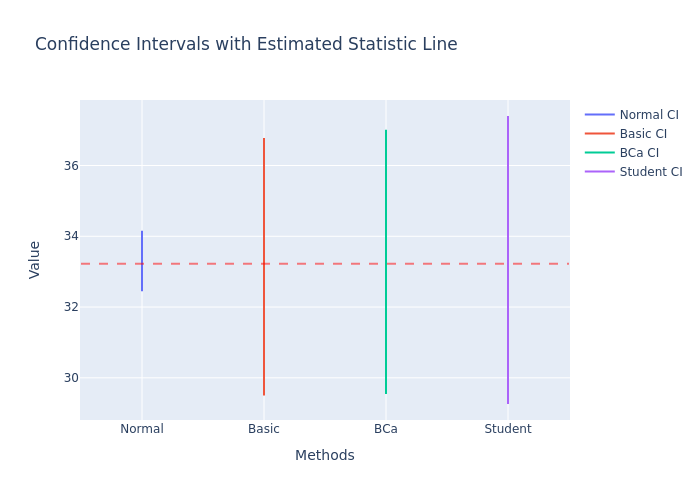

In [625]:
plot_confidence_intervals(results.loc[results["Metric"] == "mean", "Method"], 
    results.loc[results["Metric"] == "mean", "CILower"], 
    results.loc[results["Metric"] == "mean", "CIUpper"], 
    data.mean(),
    fig_type="png")


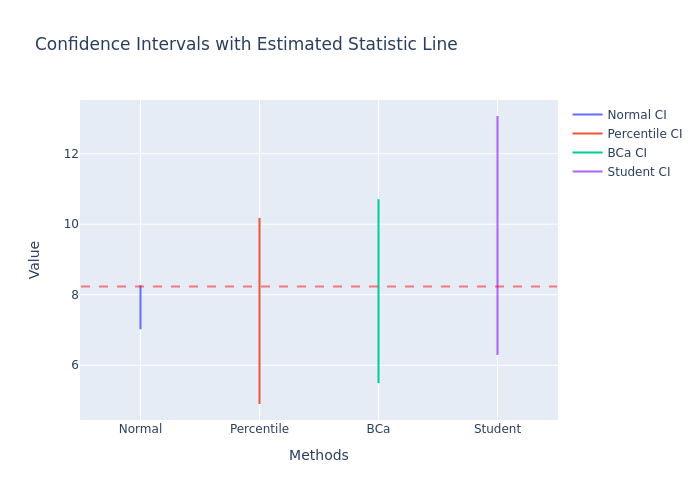

In [626]:
plot_confidence_intervals(
    results.loc[results["Metric"] == "std", "Method"], 
    results.loc[results["Metric"] == "std", "CILower"], 
    results.loc[results["Metric"] == "std", "CIUpper"],
    data.std(),
    fig_type="png")
